# Mood-RL Demonstrations

Based on [Eldar & Niv (2015)](https://www.nature.com/articles/ncomms7149): *Interaction between emotional state and learning underlies mood instability*. 

## Reinforcement Learning Model
In traditional reinforcement learning models, the expected value ($v$) of a stimulus is updated according to a reward prediction error ($\delta$), which reflects the difference between the actual reward obtained ($r$) and the expected value ($\delta = r - v$). This simple framework has proved successful in explaining a wide range of behavioral and neural data. 

To account for effects of mood on valuation, the model is modified to compute predictions errors with respect to *perceived reward* rather than actual reward: 

> $\delta = r_\text{perceived} - v$

where perceived reward ($r_\text{perceived}$) is different from actual reward in that it reflects the biasing effect of mood ($m$):

> $r_\text{perceived} = r \cdot f^m$

Here, $m \in (-1,1)$ where a good mood is indicated by $0 < m < 1$, and a bad mood is indicated by $-1 < m < 0$). $f$ is a positive constant that indicates the direction and extent of the mood bias. If $f=1$, moos does not bias the perception of reward. If $f>1$, mood exerts positive feedback as reward is perceived as larger in a good mood and smaller in a bad mood. Conversely, if $0 < f < 1$, mood exerts negative feedback as reward is perceived as smaller in a good mood and larger in a bad mood. 

To model the effects of unexpected outcomes on mood, mood is assumed to reflect recent prediction-error history ($h$), tracked using a step-size parameters $\eta_h$:

> $h = h + \eta_h (\delta - h)$

and is constrained to -1 and 1 by a sigmoid function:

> $m = \text{tanh} \ h$

Similar to traditional reinforcement learning models, expected values are updated after every trial according to the reward prediction error with a step-size (learning rate) parameter $\eta_v$:

> $v = v + \eta_v \delta$

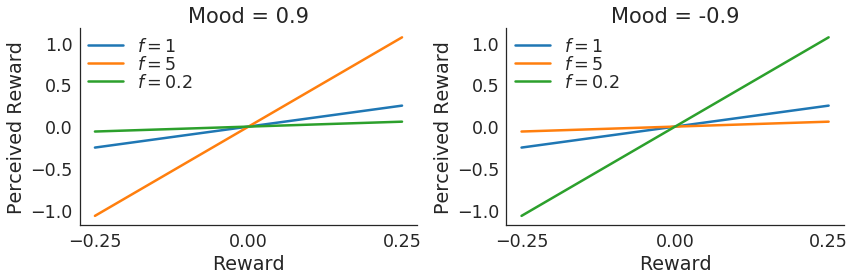

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

## Define bias function and rewards.
bias = lambda x, f, m: x * f ** m
reward = np.linspace(-0.25, 0.25, 101)

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4))

## Plot.
for ax, m in zip(axes, [0.9, -0.9]):
    
    for f in [1, 5, 0.2]:
        
        ax.plot(reward, bias(reward, f, m), lw=2.5, label=r'$f = %s$' %f)
    
    ax.set(xticks=np.linspace(reward.min(),reward.max(),3), xlabel='Reward',
           ylabel='Perceived Reward', title='Mood = %s' %m)
    ax.legend(loc=2, borderpad=0, labelspacing=0)
    
sns.despine()
plt.tight_layout()

## Task Design
For complete details of the task design, please see the original manuscript. Of relevance here are three task design features:

1. **Slot machine comparison balance:** trial types are balanced within block. In other words, trials wherein 20% and 40% probability machines are compared are presented the same number of times as trials wherein 20% and 60% probability machines are compared.
2. **Within-subject trial randomization:** trial presentation order are randomized within block. In other words, the likelihood of observing any pair of trials (e.g. *20% vs. 40% probability* then *20% vs. 60% probability*) is approximately equal across participants. Within participants, this balancing is not guaranteed. 
3. **Between-subject trial randomization:** trials are randomized across participants. In other words, every participant will observe a unique order of presented trials. 
4. **Outcome randomization:** rewards are truly randomized. In other words, though the average reward probability of each machine across participants is as designed (i.e. 20%, 40%, 60%), there is variability within participants' experience (e.g. 15%, 45%, 65%).

## Demonstrations

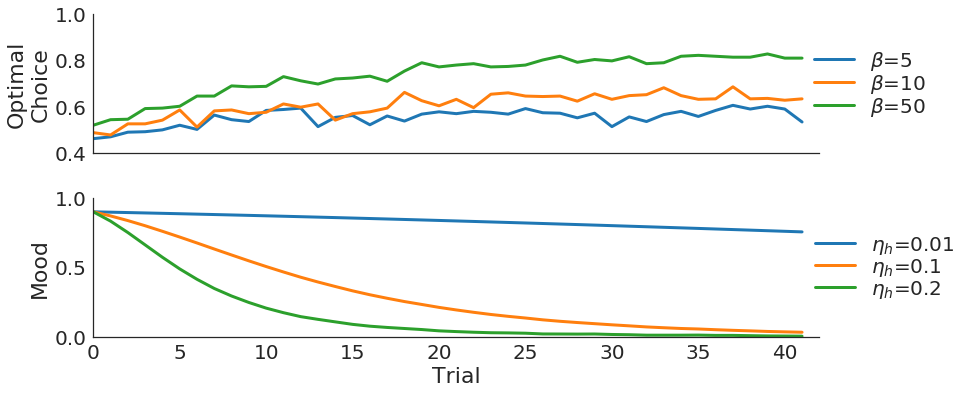

In [2]:
from scripts.simulations import *
sns.set_context('notebook', font_scale=2)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Agent parameters, by column:
## - Inverse temperature (beta)
## - Learning rate (eta_v)
## - Mood volatility (eta_h)
## - Bias function (f)
parameters = [(5,  0.2, 0.01, 1.0),
              (10, 0.2, 0.1, 1.0),
              (50, 0.2, 0.2, 1.0)]

## Initial values.
Q = 0.0
M = 0.9

## Task parameters.
probabilities = (0.2, 0.4, 0.6)
reward = 0.25
n_trials = 42

## Simulation parameters.
n_simulations = 500

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
choices = np.zeros((n_simulations, len(parameters), n_trials))
rewards = np.zeros_like(choices)
moods = np.zeros_like(rewards)

## Main loop.
for i in range(n_simulations):
    
    ## Simulate slot machine game.
    X, R = slot_machine_game(n_trials=n_trials, probabilities=probabilities, reward=reward)

    for j, params in enumerate(parameters):

        ## Initialize agent.
        agent = MoodyAgent(*params)
    
        ## Play block of slot machine game.
        Y, M = agent.simulate(X, R, Q=Q, M=M)
        moods[i,j] = M

        ## Compute optimal choices.
        choices[i,j] = optimal_choice(Y, X)
        
        ## Compute cumulative reward.
        rewards[i,j] = cumulative_reward(Y, R)
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas. 
fig, axes = plt.subplots(2,1,figsize=(12,6))

## Plot optimal choice / mood.
for i, params in enumerate(parameters): 
    
    axes[0].plot(choices[:,i].mean(axis=0), lw=3, label=r'$\beta$=%s' %params[0])
    axes[1].plot(moods[:,i].mean(axis=0), lw=3, label=r'$\eta_h$=%s' %params[2])

## Add info.
axes[0].set(xlim=(0,n_trials), xticks=[], ylim=(0.4,1.0), ylabel='Optimal\nChoice')
axes[0].legend(loc=7, bbox_to_anchor=(1.16,0.5), borderpad=0, labelspacing=0)
axes[1].set(xlim=(0,n_trials), xlabel='Trial', ylim=(0,1), ylabel='Mood')
axes[1].legend(loc=7, bbox_to_anchor=(1.2,0.5), borderpad=0, labelspacing=0)

sns.despine()
plt.tight_layout()

## Oscillatory dynamics in mood

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Agent parameters.
parameters = [(1, 0.2, 0.2, 1.0),
              (1, 0.2, 0.2, 1.2)]
Q = 0
M = 0

## Simulation parameters.
n_simulations = 250
n_trials = 500

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
evs = np.zeros((n_simulations, len(parameters), n_trials))
moods = np.zeros_like(evs)

## Generate design matrix.
X = np.ones((n_trials,1)) * 10

## Main loop.
for i in range(n_simulations):

    for j, params in enumerate(parameters):

        ## Initialize agent.
        agent = MoodyAgent(*params)
    
        ## Play block of slot machine game.
        y, M, Q = agent.simulate(X, Q=Q, M=M)
        
        evs[i,j] = Q.squeeze()
        moods[i,j] = M
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

fig, axes = plt.subplots(2,1,figsize=(12,6))
for j in range(len(parameters)):
    
    axes[0].plot(evs[:,j].mean(axis=0), lw=3)
    axes[0].set(xticks=[], ylabel='Expected\nValue')
    
    ## Plot mood.
    axes[1].plot(moods[:,j].mean(axis=0), lw=3)
    axes[1].set(xticks=[], ylabel='Mood')
    
sns.despine()
plt.tight_layout()